In [1]:
%matplotlib notebook
import mpld3
mpld3.enable_notebook()
import numpy as np
import wfdb as wb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

In [2]:
from scipy import signal
def resample_signals1(ecg_signal,bp_signal, fs, fsOrg):
    sampling_factor = fs/fsOrg
    ecg_rs_len = sampling_factor*len(ecg_signal)
    bp_rs_len = sampling_factor*len(bp_signal)
    if(fsOrg!=250):
        ecg_res = signal.resample(ecg_signal,int(ecg_rs_len))
        bp_res = signal.resample(bp_signal,int(bp_rs_len))
    else:
        ecg_res = ecg_signal
        bp_res = bp_signal
    return ecg_res,bp_res

In [3]:
import math
def normalize_ecg_signals(ekg_resamp,fs):
    
    Sstd_ecg = ekg_resamp
    if((fs/5) %2 !=0):
        mfil1_ecg=scipy.signal.medfilt(Sstd_ecg,int(fs/5))
    elif((fs/5) %2 ==0):
        mfil1_ecg=scipy.signal.medfilt(Sstd_ecg,int((fs/5))+1)
    if(((fs/5)*3) %2 !=0):
        mfil2_ecg=scipy.signal.medfilt(mfil1_ecg,int(3*(fs/5)))
    elif(((fs/5)*3) %2 ==0):
        mfil2_ecg=scipy.signal.medfilt(mfil1_ecg,int((3*(fs/5)))+1)
    
    # baseline removal
    Norm_ecg = Sstd_ecg - mfil2_ecg
    
    # normalization with the non-overlapping window size of two seconds
    w_size = 720
    N = math.ceil(len(Norm_ecg)/w_size)
    for w_strt in range(0,N):
        
        if((w_strt*720)+720<len(Norm_ecg)):
            window_ecg = Norm_ecg[w_strt*720:(w_strt*720)+720]
            abs_peak_ecg = np.max([abs(k) for k in window_ecg])
            Norm_ecg[w_strt*720:(w_strt*720)+720] = window_ecg/abs_peak_ecg
            
        elif((w_strt*720)+720>len(Norm_ecg)):
            window_ecg = Norm_ecg[w_strt*720:len(Norm_ecg)]
            abs_peak_ecg = np.max([abs(k) for k in window_ecg])
            Norm_ecg[w_strt*720:len(Norm_ecg)] = window_ecg/abs_peak_ecg
            
    return Norm_ecg

In [4]:
def Activation(signal,function):
    if(function == 'relu'):
        signal_array = np.array(signal) 
        signal_array[signal_array<0] = 0
        return signal_array
    elif(function == 'sigmoid'):
        return 1/(1+np.exp(-1*signal))
    elif(function == 'tanh'):
        return np.tanh(signal)

In [5]:
import scipy.io 
def detect_r_peak(ecg_channel, ecg_fs):
    
    # read_file = scipy.io.loadmat('========== File path .mat ===========') 
    # signal1 = read_file['val'][0]
    theta = scipy.io.loadmat('G:\Ramu_Pittala\AFib Detection\High_score_entry_2014\TrainParam_chnge3_a_numFil3_filtDim_50_iter_4.mat')
    
    #===================** trained parameters extraction **=========================#
    image_dimX = theta['imageDimX'][0,0]
    image_dimY = theta['imageDimY'][0,0]
    filt_dimX = theta['filterDimX'][0,0]
    filt_dimY = theta['filterDimY'][0,0]
    numFilters = theta['numFilters'][0,0]
    numClasses = theta['numClasses'][0,0]
    pool_dim = theta['poolDim'][0,0]
    indA = filt_dimX*filt_dimY*int(numFilters)
    hiddenSize = numFilters*((image_dimX-filt_dimX+1)*(image_dimY-filt_dimY+1))
    indB = numClasses*hiddenSize
    Conv_weights = theta['opttheta'][0:indA,0]
    dense_weights = theta['opttheta'][indA:indA + indB]
    indC = indA + indB
    Conv_bias_weights = theta['opttheta'][indC:indC + numFilters]
    indD = indC + numFilters
    dense_bias_weights = theta['opttheta'][indD:len(theta['opttheta'])]

    d_length = int((len(dense_weights))/2)
    dense_wts_class0  = [dense_weights[int(2*j)][0] for j in range(0,d_length) if 2*j<len(dense_weights)]
    dense_wts_class1  = [dense_weights[int(2*i+1)][0] for i in range(0,d_length) if 2*i+1<len(dense_weights)]
    #===============================================================================#
    
    #========================= Driver code =========================================#
    ecg_signal = ecg_channel
    bp_signal = np.zeros(len(ecg_signal),dtype = float)
    fs = 250
    fsOrg = ecg_fs

    #==== 1. Resampling and Preprocessing ==============#

    ecg_resamp,bp_resamp = resample_signals1(ecg_signal,bp_signal,fs,fsOrg)
    norm_ecg = normalize_ecg_signals(ecg_resamp,fs)

    final_ecg = norm_ecg
    final_bp = np.zeros(len(final_ecg),dtype = int)

    final_signal = np.vstack((final_ecg,final_bp))
    
    #===================================================#
    
    #==== 2. Convolution and FC Operation ==============#

    #numFilters = 1
    Conv_length = len(final_signal.transpose())-theta['filterDimX'][0][0]+1    #len(test_data_full)-72+1, len(data)-filter_size+1
    Conv_output = np.zeros((Conv_length,numFilters))
    Conv_activation = np.zeros((Conv_length,numFilters))
    Bc = np.zeros((1,numFilters), dtype = float)

    for filt in range(1,numFilters+1):

        #filter_weights = c[0].reshape(72,2)
        #Bc[:,filt] = c[1].reshape(1)
        Conv_rot = np.rot90(np.reshape((Conv_weights[(filt-1)*filt_dimX*2:filt*filt_dimX*2]),(filt_dimX,2)).transpose(),2)
        Conv_output[:,filt-1] = np.reshape(signal.convolve2d(final_signal,Conv_rot,'valid'),Conv_length)
        Conv_bias = Conv_output[:,filt-1] + Conv_bias_weights[filt-1][0]*np.ones((Conv_length),dtype = float)
        Conv_activation[:,filt-1] = Activation(Conv_bias,'sigmoid')

    Flatten_output = Conv_activation[0,:]
    for f in range(1,numFilters):
        Flatten_output = np.concatenate((Flatten_output,Conv_activation[f,:]))


    Wdf = np.reshape(dense_weights,(numFilters,image_dimX-filt_dimX+1,numClasses))

    Bd = dense_bias_weights

    conv_len = np.shape(Conv_activation)[0]-np.shape(Wdf)[1]+1 
    numClasses = 2

    weightConv = np.zeros(conv_len)
    weightConvb = np.zeros((numClasses,conv_len), dtype = float)

    for j in range(0,numClasses):
        Wop = np.rot90(Wdf[:,:,j],2)
        weightConv = signal.convolve2d(Conv_activation.transpose(),Wop,'valid') 
        weightConvb[j,:] = weightConv + Bd[j][0]*np.ones((1,np.size(weightConv)),dtype = float)


    preds = np.zeros((2,np.shape(weightConv)[1]),dtype = float)
    probs = np.zeros(np.shape(weightConv)[1],dtype = float)

    for spl in range(0,np.shape(weightConv)[1]):
        preds[0,spl] = np.exp(weightConvb[0,spl]-max(weightConvb[:,spl]))/sum(np.exp(weightConvb[:,spl]-max(weightConvb[:,spl])))
        preds[1,spl] = np.exp(weightConvb[1,spl]-max(weightConvb[:,spl]))/sum(np.exp(weightConvb[:,spl]-max(weightConvb[:,spl])))
        probs[spl] = max(preds[0,spl],preds[1,spl])


    # Label_chnk = delete_spurious(probs[0:1000])
    Labels_final = signal.convolve([0]*125 + list(preds[1,:]) + [0]*125,np.ones(3),'valid') #signal.convolve(Label_chnk,np.ones(3),'valid')

    labels_final = [0]*len(Labels_final)
    labels_final = [round(Labels_final[r],1) for r in range(0,len(Labels_final))]
    
    #==============================================#
    
    #===== 3. Locating R-peaks ====================#
    
    where_nans = np.isnan(labels_final)
    for na in range(0,len(where_nans)): 
        if (where_nans[na]==True):
            labels_final[na]=0 

    avg = np.mean(labels_final)+0.2
    labels_final1 = [0]*len(labels_final)

    maximum = max(labels_final)
    minimum = min(labels_final)

    for q in range(0,len(labels_final)):
        if(labels_final[q]>=avg):
            labels_final1[q] = maximum
        else:
            labels_final1[q] = minimum

    difference = abs(labels_final1 - np.hstack((labels_final1[1:],0)))
    diff_avg = (max(difference) + min(difference))/2
    all_max_loc = [p for p in range(0,len(difference)) if difference[p]>diff_avg]
    r_peak_loc = []
    for h in range(0,int(len(all_max_loc)/2)):
        r_peak_loc.append(int((all_max_loc[h*2] + all_max_loc[h*2 + 1])/2))

    R_peak_locations = [int(i*(fsOrg/fs)) for i in r_peak_loc]
    #=============================================#
    
    
    return R_peak_locations

In [7]:
read_file = scipy.io.loadmat('G:/Ramu_Pittala/HRV_Analysis/mimic_testing/86090.mat')
#signal1 = read_file['ECG_44083'][0]
signal1 = read_file['val'][0]
detect_r_peak(signal1, 125)

[137,
 232,
 289,
 329,
 428,
 528,
 627,
 725,
 823,
 921,
 1016,
 1074,
 1115,
 1173,
 1214,
 1313,
 1370,
 1408,
 1466,
 1505,
 1564,
 1605,
 1692,
 1801,
 1897,
 1953,
 1992,
 2091,
 2190,
 2285,
 2381,
 2440,
 2481,
 2579,
 2635,
 2673,
 2772,
 2830,
 2872,
 2969,
 3026,
 3063,
 3121,
 3162,
 3258,
 3358,
 3453,
 3551,
 3608,
 3645,
 3705,
 3743,
 3807,
 3842,
 3905,
 3941,
 4001,
 4040,
 4102,
 4110,
 4138,
 4197,
 4238,
 4338,
 4437,
 4533,
 4630,
 4689,
 4730,
 4829,
 4928,
 5023,
 5121,
 5221,
 5318,
 5415,
 5474,
 5515,
 5614,
 5713,
 5809,
 5908,
 6007,
 6106,
 6204,
 6301,
 6358,
 6399,
 6457,
 6498,
 6556,
 6597,
 6696,
 6793,
 6851,
 6893,
 6992,
 7090,
 7188,
 7285,
 7384,
 7483,
 7581,
 7679,
 7776,
 7874,
 7973,
 8071,
 8170,
 8268,
 8363,
 8461,
 8559,
 8655,
 8750,
 8843,
 8936,
 9030,
 9125,
 9219,
 9317,
 9408,
 9502,
 9597,
 9693,
 9788,
 9882,
 9976,
 10068,
 10162,
 10253,
 10350,
 10444,
 10537,
 10630,
 10724,
 10820,
 10915,
 11007,
 11101,
 11197,
 11293,
 1

<IPython.core.display.Javascript object>


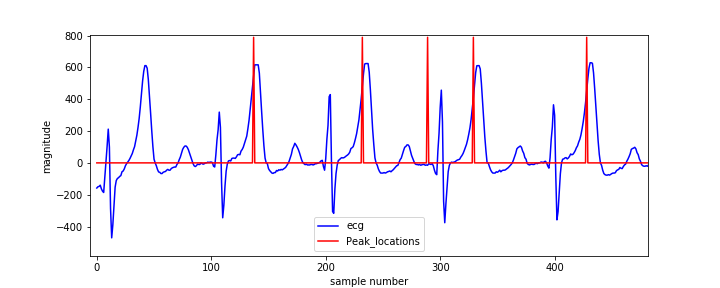

In [12]:
# ==================  plotting r-peak locations ===================================#
p_signal = [0]*len(signal1)
R_peak_locations = detect_r_peak(signal1, 125)
for i in R_peak_locations:
    p_signal[i] = np.max(signal1)

# normalize_factor = 1/max(bp_signal)
# bp_channel = bp_signal*(normalize_factor)

fig = plt.figure(figsize = (10,4),dpi = 72)
Label1, = plt.plot(signal1,'blue',label= 'ecg')
# Label2, = plt.plot(bp_channel,'g',label= 'bp')
# plt.plot(Conv_activation[2,:]+Conv_activation[1,:]+Conv_activation[0,:],'orange')
# Label3, = plt.plot(Labels_final1,'orange', label= 'Final labels')
# Label4, = plt.plot(Conv_activation[1,:],'red', label= 'filter2 output')
Label2, = plt.plot(p_signal,'red', label = 'Peak_locations')
plt.xlabel('sample number')
plt.ylabel('magnitude')
plt.legend(handles=[Label1,Label2])
# =================================================================================#